# Прогнозирование индекса промышленного производства

Для предсказания изменений в индексе промышленного производства применяется методика градиентного бустинга с использованием библиотеки CatBoost

### Определяющие признаки:
- Новостной индекс ЦБ (news)
- Индекс цен на электроэнергию в первой ценовой зоне (consumer_price)
- Промышленность (cb_monitor)
- Индикатор бизнес климата (bussines_clim)
- Курс рубля (curs)
- Погрузка на сети РЖД (rzd)

Каждый признак имеет разный лаг эффекта на экономику. Поэтому для различных прогнозов будут созданы столбцы с лагами __(с постфиксом lag_i)__ Более того, при прогнозе более чем на месяц, новостной индекс ЦБ имеет все большую предсказательную силу

Для каждого из трех прогнозируемых периодов обучается отдельная модель, поскольку лаг-переменные, отражающие временные сдвиги в воздействии факторов, фактически представляют собой новые признаки

## Импорт библиотек и установка зависимостей

In [1]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/pycups-2.0.1-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/PyPDF3-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.6 MB/s eta 0:00:00m eta 0:00:010:00:01


In [39]:
import pandas as pd
import datetime
import numpy as np

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# Импорт данных

In [365]:
df = pd.read_csv('../data/preprocessed_ipp_factors.csv', index_col='Unnamed: 0')

df.date = pd.to_datetime(df.date).dt.date

In [148]:
df.head(3)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd,exchange_rate
0,2015-01-31,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6,15.380952
1,2015-02-28,99.8,-1.756337,1156.01,-11.936877,2.572276,64.518174,92.5,13.789474
2,2015-03-31,101.9,-1.972270,1167.50,-7.194668,6.963493,60.363090,103.0,13.409091


# Добавление столбцов с лаггом

### Лаги для признаков:
- __Новостной индекс ЦБ (news):__ 1 месяц
- __Индекс цен на электроэнергию в первой ценовой зоне (consumer_price):__ 0 месяцев
- __Промышленность (cb_monitor):__ 2 месяца
- __Индикатор бизнес климата (bussines_clim):__ 2 месяца
- __Курс рубля (curs):__ 0 месяцев
- __Погрузка на сети РЖД (rzd):__ 1 месяц
- __Среднемесячная ключевая ставка ЦБ (exchange_rate)__: 

In [91]:
df.head(1)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd,exchange_rate
0,2015-01-31,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6,15.380952


In [388]:
for i in range(1, 3 + 1):
    df[f'goal_lag_{i}'] = df['goal'].shift(i) ** 2
    df[f'news_lag_{i}'] = df['news'].shift(i)
    df[f'bussines_clim_lag_{i}'] = df['bussines_clim'].shift(i)
    df[f'cb_monitor_lag_{i}'] = df['cb_monitor'].shift(i)
    df[f'rzd_lag_{i}'] = df['rzd'].shift(i)
    # df[f'exchange_rate_lag_{i}'] = df['exchange_rate'].shift(i)
df[f'exchange_rate_lag_8'] = df['exchange_rate'].shift(9)
df[f'exchange_rate_lag_9'] = df['exchange_rate'].shift(9)
df[f'exchange_rate_lag_10'] = df['exchange_rate'].shift(9)

df = df.fillna(method='pad')

In [389]:
df.head(3)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd,exchange_rate,goal_lag_1,...,cb_monitor_lag_2,rzd_lag_2,goal_lag_3,news_lag_3,bussines_clim_lag_3,cb_monitor_lag_3,rzd_lag_3,exchange_rate_lag_8,exchange_rate_lag_9,exchange_rate_lag_10
0,2015-01-31,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6,15.380952,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-28,99.8,-1.756337,1156.01,-11.936877,2.572276,64.518174,92.5,13.789474,10261.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-03-31,101.9,-1.972270,1167.50,-7.194668,6.963493,60.363090,103.0,13.409091,9960.04,...,-20.468123,96.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Ключевая ставка

В зависимости от лага (6-9 месяцев) или 2 года меняется коэффициент корреляции между 

Связь ИПП и ключевой ставки очевидно отрицательна, но дальнейший рост видимо вызван именно правильной политикой ЦБ, которая и приводит к росту промышленности после антикризисных мер

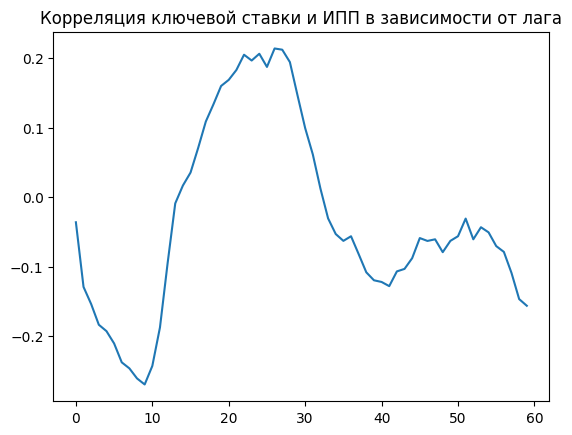

In [234]:
plt.title('Корреляция ключевой ставки и ИПП в зависимости от лага')

plt.plot(range(60), [df['exchange_rate'].shift(i).corr(df.goal) for i in range(60)])

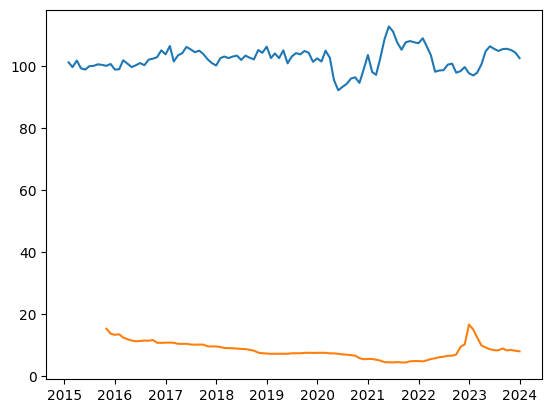

In [152]:
plt.plot(df.date, df.goal)
plt.plot(df.date, df.exchange_rate.shift(9))

In [153]:
# Лаг в 9 месяцев
df['exchange_rate']\
    .shift(9)\
    .corr(df.goal)

-0.26975355896241526

In [154]:
# Лаг в 2 года
df['exchange_rate']\
    .shift(24)\
    .corr(df.goal)

0.20642284164738492

## Корреляция ИПП с признаками (с лаггом)

экзогенные переменные для прогнозирования на 1 месяц вперед

In [398]:
exog_var = ['news_lag_1', 'consumer_price', 'cb_monitor_lag_2', 'bussines_clim_lag_1', 'curs', 'rzd_lag_1', 'exchange_rate_lag_9']

<Axes: >

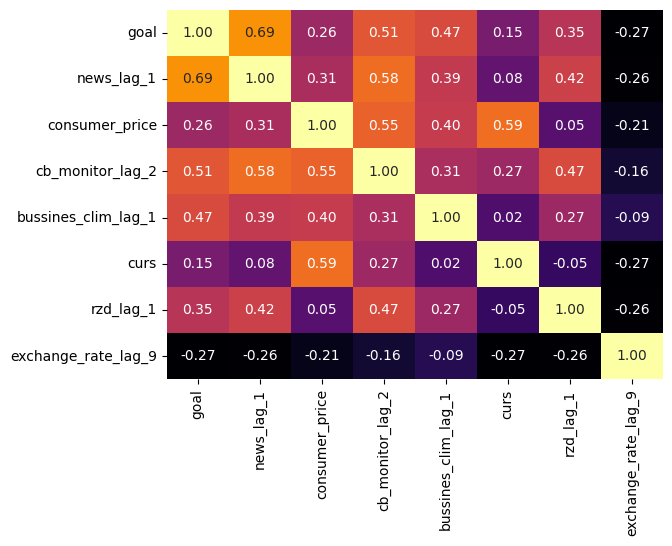

In [399]:
sns.heatmap(
    df[['goal'] + exog_var].corr(),
    fmt=".2f",
    # ax=ax,
    annot=True,
    cmap='inferno',
    cbar=False
)

Заметим, что cb_monitor и bussines_clim сильно коррелируемы: попробуем с помощью метода главных компонентов выделить главную компоненту

# Определим порядок признаков для модели CatBoost

Порядок признаков важен для модели, сортировать их по корреляции не очень правильно, поэтому экономически обоснуем их порядок

1. Первым пойдет новостной индекс, поскольку на производство достаточно сильно влияют настроения в обществе и этот индекс лучше всего это отражает
2. Далее, идут индексы для бизнеса в россии
3. Потом ключевая ставка
4. Потом поставки РЖД
5. В конце курс, потому что производство в РФ все меньше зависит от импорта и курса валют

In [445]:
exog_var = [
    'news_lag_1',
    'cb_monitor_lag_2',
    'bussines_clim_lag_1',
    'exchange_rate_lag_9',
    'rzd_lag_1',
    'consumer_price',
    'curs'
]

# Сделаем прогноз на 1 месяц

Для этого обучим модель по следующим признакам:

In [102]:
from sklearn.model_selection import train_test_split

Поделим на обучающую и тестовую выборку 80/20

In [446]:
X_train, X_test, Y_train, Y_test = train_test_split(df[exog_var], df.goal, test_size=0.2, random_state=42)

In [447]:
model = CatBoostRegressor(
        iterations=4,
        learning_rate=1,
        depth=4,
        verbose=False, 
        loss_function='RMSE',
        l2_leaf_reg = 1
    )

grid = {
    'iterations':    [2, 4, 6, 8, 15], 
    'depth':         [3, 6, 8],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}

res = model.grid_search(
    grid, X_train, Y_train, 
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True, verbose=0,
    # cv=tscv
)


bestTest = 101.4761413
bestIteration = 1


bestTest = 99.6496797
bestIteration = 1


bestTest = 82.29517252
bestIteration = 1


bestTest = 25.23771088
bestIteration = 1


bestTest = 3.174099451
bestIteration = 0


bestTest = 101.4762682
bestIteration = 1


bestTest = 99.65093911
bestIteration = 1


bestTest = 82.30686366
bestIteration = 1


bestTest = 25.27636743
bestIteration = 1


bestTest = 3.168761812
bestIteration = 0


bestTest = 101.4784124
bestIteration = 1


bestTest = 99.67223154
bestIteration = 1


bestTest = 82.50488819
bestIteration = 1


bestTest = 25.96161474
bestIteration = 1


bestTest = 3.931975775
bestIteration = 1


bestTest = 101.4857812
bestIteration = 1


bestTest = 99.7454301
bestIteration = 1


bestTest = 83.18893423
bestIteration = 1


bestTest = 28.59390568
bestIteration = 1


bestTest = 10.24007477
bestIteration = 1


bestTest = 101.4924027
bestIteration = 1


bestTest = 99.81120938
bestIteration = 1


bestTest = 83.80431247
bestIteration = 1


bestTest = 3

In [448]:
res['params']

{'depth': 3, 'learning_rate': 0.5, 'l2_leaf_reg': 0.005, 'iterations': 15}

In [449]:
model = CatBoostRegressor(**res['params'], verbose = False)
model.fit(X_train, Y_train)

### Качество модели:

In [134]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [450]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score: {np.round(r2_score(Y_train, train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(Y_train, train_predict), 3) * 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(Y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.916
mape train: 0.8%
mape test: 1.7%


# Пробуем поменять параметры

Есть гипотеза, что нужно выделить главную компоненту из cb_monitor и bussines_clim, поскольку они очень коррелируемы

In [266]:
df.cb_monitor\
    .corr(df.bussines_clim)

0.7878607126804216

Создадим модели без каждой из них и сравним качество метрик

### Без бизнес климата:

In [406]:
new_exog_var = ['news_lag_1', 'cb_monitor_lag_2', 'exchange_rate_lag_9', 'rzd_lag_1', 'consumer_price', 'curs']

X_train, X_test, Y_train, Y_test = train_test_split(df[exog_var], df.goal, test_size=0.2, random_state=42)

model = CatBoostRegressor(**res['params'], verbose=False)
model.fit(X_train, Y_train)

In [407]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score: {np.round(r2_score(Y_train, train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(Y_train, train_predict), 3)* 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(Y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.895
mape train: 0.8%
mape test: 1.3%


### Без cb_monitor

In [408]:
new_exog_var = ['news_lag_1', 'bussines_clim_lag_1', 'exchange_rate_lag_8', 'rzd_lag_1', 'consumer_price', 'curs']

X_train, X_test, Y_train, Y_test = train_test_split(df[new_exog_var], df.goal, test_size=0.2, random_state=42)

model = CatBoostRegressor(**res['params'], verbose=False)
model.fit(X_train, Y_train)

In [409]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score: {np.round(r2_score(Y_train, train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(Y_train, train_predict), 3)* 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(Y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.894
mape train: 0.9%
mape test: 2.0%


В первом случае R^2 упал, а MAPE на тестовой и обучающей выборке отличается незначительно, (раньше в 2 раза отличались) видимо было переобучение

Также MAPE уменьшился на 4 процентных пункта

Получается, нужно использовать только cb_monitor 

# Модель для прогноза на 2 месяца

In [420]:
exog_var_2 = ['news_lag_2', 'cb_monitor_lag_3', 'bussines_clim_lag_2', 'exchange_rate_lag_9', 'rzd_lag_2', 'consumer_price', 'curs']

X_train, X_test, Y_train, Y_test = train_test_split(df[exog_var_2], df['goal_lag_1'], test_size=0.2, random_state=42)

model_2 = CatBoostRegressor(**res['params'], verbose=False)
model_2.fit(X_train, Y_train)

train_predict = model_2.predict(X_train)
test_predict = model_2.predict(X_test)

print(f'r2_score: {np.round(r2_score(Y_train, train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(Y_train, train_predict), 3)* 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(Y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.932
mape train: 1.3%


ValueError: Input contains NaN.

In [421]:
model_2.predict(df[exog_var_2].iloc[-3]) ** 0.5

104.98250337272762

# Визуализация

In [460]:
forecast = pd.DataFrame(columns=['date', 'goal_predict'])
forecast.date = [datetime.date(year=2024, month=i, day=27) for i in range(1, 3 + 1)]

In [461]:
forecast.goal_predict.iloc[0] = model.predict(df[exog_var].iloc[-1])
forecast.goal_predict.iloc[1] = model_2.predict(df[exog_var_2].iloc[-1]) ** 0.5

In [462]:
forecast

,date,goal_predict
0,2024-01-27,103.909897
1,2024-02-27,104.982503
2,2024-03-27,NaN


(17986.0, 19908.0)

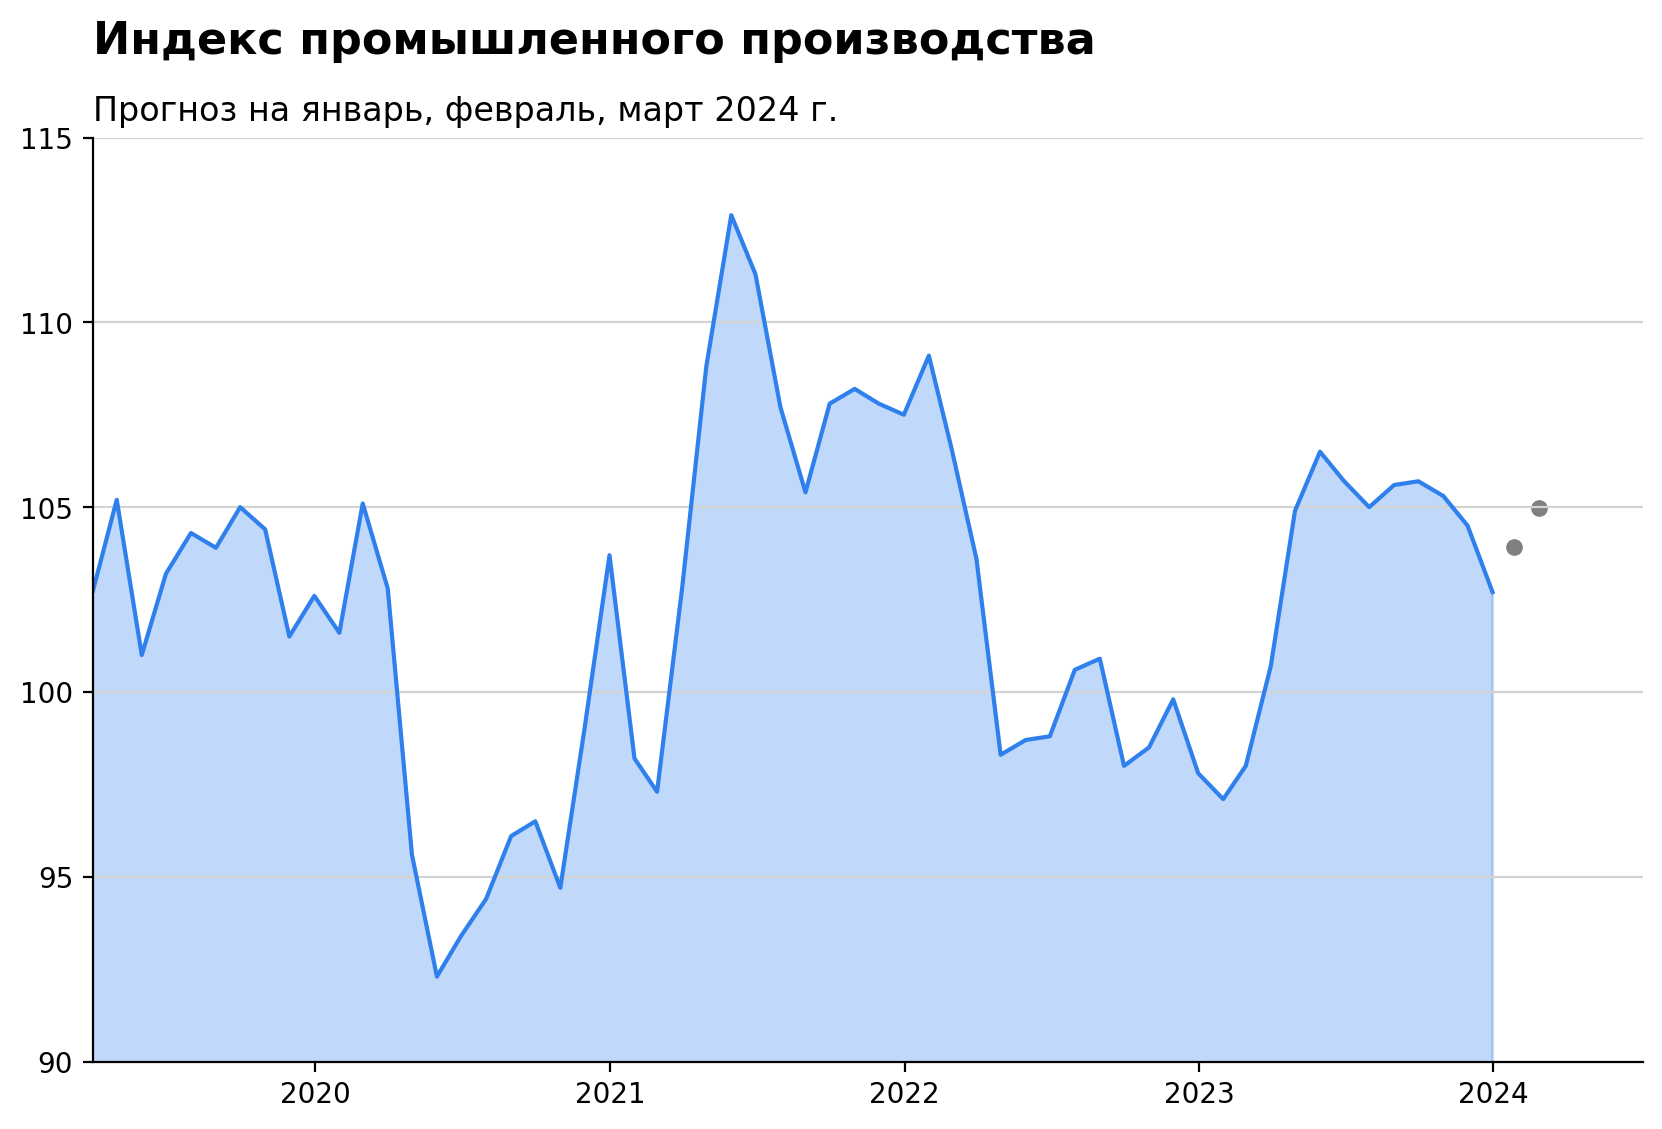

In [463]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

fig.text(y=.95, x=.125, s="Индекс промышленного производства",fontsize=16, fontweight="bold")
plt.title("Прогноз на январь, февраль, март 2024 г.",fontsize=12, loc='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(axis='y', color='lightgrey')

ax.plot(df.date, df.goal, color='#2F80ED')
ax.fill_between(df.date, df.goal, color='#2F80ED', alpha=0.3)

ax.scatter(forecast.date, forecast.goal_predict, color='grey', s=25)

ax.set_ylim([90, 115])
ax.set_xlim([df.date.iloc[50], df.date.iloc[-1] + datetime.timedelta(days=31 * 6)])